# EDA

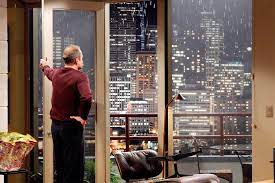

In [ ]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


from matplotlib.ticker import PercentFormatter
plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"
pd.plotting.register_matplotlib_converters()
pd.set_option('display.float_format', lambda x: '%.3f' % x)

### Importing Data

In [ ]:

# as column 'condition' is truncated in the display, disable column truncation
pd.set_option('display.max_columns', None) 
pd.set_option('display.width', None) 
pd.set_option('display.max_colwidth', -1)

### Checking Data

In [ ]:
# Create DataFrame 
df = pd.read_csv('./data/King_County_House_prices_dataset.csv')

In [ ]:
df.describe()

In [ ]:
df.head()

In [ ]:
df.columns

In [ ]:
df.info()

In [ ]:
df.isnull()

In [ ]:
# check how many duplicated rows exist in the data frame
df.duplicated().value_counts()
# no duplicates

To determine from which year/s the data is transform date:

In [ ]:
#type(df['date'][0])

df_year = df['date'].apply(lambda date: date.split('/')[-1])
df_year.unique()

## My Hypothoses:


* The more sqft_living a house has, the more expensive it is. (Check price and price per sqft.)
    * The more rooms a house has, the more expensive it is.
    * The more bathrooms a house has, the more expensive it is.

<br>

* The sale price increases with the proximity to the city center.
    
<br>

* The better the condition of the house, the more expensive it is.

<br>

### Cleaning Data

Start dropping columns when correlation between column and price is weak or moderate. 
<br>

#### Correlation relationship definition:
* Correlation coefficient of 1 -> Perfect relationship
* Correlation coefficient between -0.7 and 1 or 0.7 and 1 -> Very strong relationship 
* Correlation coefficient between -0.5 and -0.7 or 0.5 and 0.7 -> Strong relationship
* Correlation coefficient between -0.3 and -0.5 or 0.3 and 0.5 -> Moderate relationship
* Correlation coefficient between 0 and -0.3 or 0 and 0.3 -> Weak relationship
* Correlation coefficient of 0 -> No relationship

<br>

In [ ]:
# Drop the ID and date column: won't need it 
df = df.drop(['id', 'date'], axis=1)
df.head()

In [ ]:
# correlation between column waterfront and column price
correlation = df['waterfront'].corr(df['price'])
print(correlation.round(1))

# correlation is weak/moderate -> drop column waterfront
df = df.drop('waterfront', axis=1)
df.head()

In [ ]:
# correlation between column floors and column price
correlation = df['floors'].corr(df['price'])
print(correlation.round(1))

# correlation is weak/moderate -> drop column floors
df = df.drop('floors', axis=1)
df.head()

In [ ]:
# correlation between column view and column price
correlation = df['view'].corr(df['price'])
print(correlation.round(1))

# correlation is moderate 

In [ ]:
# correlation between column condition and column price
correlation = df['condition'].corr(df['price'])
print(correlation.round(1))

# correlation is 0 --> drop column condition
df = df.drop('condition', axis=1)
df.head()

In [ ]:
# correlation between column grade and column price
correlation = df['grade'].corr(df['price'])
print(correlation.round(1))

# correlation is (very)strong 


In [ ]:
# Focus on column sqft_living --> drop columns: sqft_basement and sqft_above
df = df.drop(['sqft_basement', 'sqft_above'], axis=1)
df.head()

In [ ]:
# Drop columns sqft_lot and sqft_lot15, because renovations regarding annexes are not in the stakeholders interest.
df = df.drop(['sqft_lot', 'sqft_lot15'], axis=1)
df.head()

In [ ]:
df.info()  # yr_renovated is missing values: 16.198 entries but only 13.337 entries in yr_renovated 

In [ ]:
# Make correlation matrix for columns yr_built, yr_renovated and price_per_sqft, because of missing values in yr_renovated.

# make a variable to hold columns for correlation matrix:
features = ['yr_built', 'yr_renovated', 'price']
corr_matrix = df[features].corr()
print(corr_matrix.round(1))

# correlation is weak for yr_built and yr_renovated -> drop these columns
df = df.drop(['yr_built', 'yr_renovated'], axis=1)
df.head()

In [ ]:
df.describe()

Correlation for zipcodes makes no sense, because zipcodes are arbitrary numbers. Don't drop zipcodes column. Will be useful for pinpointing most interesting regions to buy houses.

Price per sqft is missing in dataset. Make new column: price_per_sqft.
<br>

In [ ]:
# Calculate price per sqft_living per house:
price_per_sqft_series= df['price']/df['sqft_living']
price_per_sqft_series.name = 'price_per_sqft'
df = pd.concat([df, price_per_sqft_series], axis=1)
df.head()

In [ ]:
df['price_per_sqft'].describe()

Make a boxplot and histogram to show the distribution of price:

In [ ]:
# Boxplot and Histogram for 'price' with mean, median, mode and percentile displayed:

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw= {"height_ratios": (0.2, 1)})
mean=df['price'].mean()
median=df['price'].median()
mode=df['price'].mode().values[0]
cutoff1=df['price'].quantile(0.25)
cutoff2=df['price'].quantile(0.75)

sns.boxplot(data=df, x="price", ax=ax_box)
ax_box.axvline(mean, color='r', linestyle='--')
ax_box.axvline(median, color='g', linestyle='-')
ax_box.axvline(mode, color='b', linestyle='-')
ax_box.axvline(cutoff1, color='black', linestyle='-.')
ax_box.axvline(cutoff2, color='black', linestyle='-.')

sns.histplot(data=df, x="price", ax=ax_hist, kde=True)
ax_hist.axvline(mean, color='r', linestyle='--', label="Mean")
ax_hist.axvline(median, color='g', linestyle='-', label="Median")
ax_hist.axvline(mode, color='b', linestyle='-', label="Mode")
ax_hist.axvline(cutoff1, color='black', linestyle='-.', label="25 %")
ax_hist.axvline(cutoff2, color='black', linestyle='-.', label="75 %")

ax_hist.legend()

ax_box.set(xlabel='')
plt.show()

In this plot we see the distribution of price. The histogram is positively skewed. That means that the average is not the mean and we should use the median for further analysis. In addition we see in the boxplot that we have a few outliers in our dataset. Clean data and remove the outliers.

<br>

In [ ]:
df.describe()

Make a boxplot and histogram to show the distribution of price_per_sqft:

In [ ]:
# Boxplot and Histogram for 'price_per_sqft' with mean, median, mode and percentile displayed:

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw= {"height_ratios": (0.2, 1)})
mean=df['price_per_sqft'].mean()
median=df['price_per_sqft'].median()
mode=df['price_per_sqft'].mode().values[0]
cutoff1=df['price_per_sqft'].quantile(0.25)
cutoff2=df['price_per_sqft'].quantile(0.75)

sns.boxplot(data=df, x="price_per_sqft", ax=ax_box)
ax_box.axvline(mean, color='r', linestyle='--')
ax_box.axvline(median, color='g', linestyle='-')
ax_box.axvline(mode, color='b', linestyle='-')
ax_box.axvline(cutoff1, color='black', linestyle='-.')
ax_box.axvline(cutoff2, color='black', linestyle='-.')

sns.histplot(data=df, x="price_per_sqft", ax=ax_hist, kde=True)
ax_hist.axvline(mean, color='r', linestyle='--', label="Mean")
ax_hist.axvline(median, color='g', linestyle='-', label="Median")
ax_hist.axvline(mode, color='b', linestyle='-', label="Mode")
ax_hist.axvline(cutoff1, color='black', linestyle='-.', label="25 %")
ax_hist.axvline(cutoff2, color='black', linestyle='-.', label="75 %")

ax_hist.legend()

ax_box.set(xlabel='')
plt.show()

In this plot we see the distribution of price_per_sqft. This graph is also positively skewed. That means that the average is not the mean and we should use the median for further analysis. In addition to that we can see that we have a high probability of outliers in our dataset. But in comparison to the graph above the skewness to the right is not as pronounced.

<br>

#### Time to get rid of the outliers:

In [ ]:
# Calculate outliers: q3 + iqr*1.5
q_25, q_75 = df['price'].quantile([0.25, 0.75])
iqr = q_75 - q_25

# Save outliers in variable:
cutoff = q_75 + (iqr * 1.5)
print(cutoff)

In [ ]:
# Look up RangeIndex
df.info()  # RangeIndex: 21597 entries, 0 to 21596

In [ ]:
# save new dataframe without outliers:
df = df[df['price'] < cutoff].reset_index(drop=True)
df.head()

In [ ]:
# check RangeIndex
df.info()  # RangeIndex: 20439 entries, 0 to 20438

In [ ]:
# Plot without outlieres in price:
# Boxplot and Histogram for 'price' with mean, median, mode and percentile displayed:

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw= {"height_ratios": (0.2, 1)})
mean=df['price'].mean()
median=df['price'].median()
mode=df['price'].mode().values[0]
cutoff1=df['price'].quantile(0.25)
cutoff2=df['price'].quantile(0.75)

sns.boxplot(data=df, x="price", ax=ax_box)
ax_box.axvline(mean, color='r', linestyle='--')
ax_box.axvline(median, color='g', linestyle='-')
ax_box.axvline(mode, color='b', linestyle='-')
ax_box.axvline(cutoff1, color='black', linestyle='-.')
ax_box.axvline(cutoff2, color='black', linestyle='-.')

sns.histplot(data=df, x="price", ax=ax_hist, kde=True)
ax_hist.axvline(mean, color='r', linestyle='--', label="Mean")
ax_hist.axvline(median, color='g', linestyle='-', label="Median")
ax_hist.axvline(mode, color='b', linestyle='-', label="Mode")
ax_hist.axvline(cutoff1, color='black', linestyle='-.', label="25 %")
ax_hist.axvline(cutoff2, color='black', linestyle='-.', label="75 %")

ax_hist.legend()

ax_box.set(xlabel='')
plt.show()

The distribution of price is still positively skewed.

<br>

### Checking the first hypothesis: 
### The more sqft_living a house has, the more expensive it is.

* What is the correlation between __price__ and __sqft_living__?             

* What is the correlation between __price_per_sqft__ and __sqft_living__?   
* What is the correlation between __price__ and __bedrooms__?              
* What is the correlation between __price_per_sqft__ and __bedrooms__?       
* What is the correlation between __price__ and __bathrooms__?              
* What is the correlation between __price_per_sqft__ and __bathrooms__?     

<br>

#### Correlations price or price_per_sqft, and sqft_living:

In [ ]:
# correlation between price and sqft_living:
correlation = df['price'].corr(df['sqft_living'])
print(correlation.round(1))

In [ ]:
fig = px.scatter(df, x='price', y='sqft_living', color='bedrooms', opacity= 0.5, title='Correlation between Price and sqft living in King County (Correlation: 0.6)')
#fig.update_traces(marker=dict(color='#40BCD8'))
fig.show()

In this scatterplot we see, that there is a moderate correlation between the price and the sqft living. More sqft living equates to a higher price.
<br>
Because there are 3 outliers in sqft_living (7480, 7120 and 7350), I will remove them.

In [ ]:
# remove three outliers
df = df[df['sqft_living'] < 7000]

In [ ]:
correlation = df['price_per_sqft'].corr(df['sqft_living'])
print(correlation.round(1))

In [ ]:
fig = px.scatter(df, x='price_per_sqft', y='sqft_living', 
                opacity= 0.5, 
                title='Correlation between Price/sqft and sqft living (correlation: -0.3)')
fig.update_traces(marker=dict(color='#40BCD8'))
fig.show()

In this scatterplot we see, that the correlation between sqft living and price per sqft is negative moderate. That was to be expected, as _price/sqft living_ scales like _1/sqft living_, but _price_ and _sqft living_ still have a positive correlation.

<br>

#### Correlations price or price_per_sqft, and bedrooms:

In [ ]:
correlation = df['price'].corr(df['bedrooms'])
print(correlation.round(1))

In [ ]:
fig = px.scatter(df, x='price', y='bedrooms', opacity= 0.5, title='Correlation between Price and bedrooms (correlation: 0.3)')
fig.update_traces(marker=dict(color='#40BCD8'))
fig.show()

In this scatterplot we can see, that there is only a moderate correlation. Bedrooms don't influence the price as much as I thought. We can see one outlier with 33 bedrooms. Remove outlier and all houses with more than 5 bedrooms, because only houses with less bedrooms are in the stakeholders interest.

<br>

In [ ]:
# remove outliers and filter for houses with 5 and less bedrooms:
df = df[df['bedrooms'] < 6]

In [ ]:
correlation = df['price_per_sqft'].corr(df['bedrooms'])
print(correlation.round(1))

In [ ]:
fig = px.scatter(df, x='price_per_sqft', y='bedrooms', 
                opacity= 0.5, title='Correlation between Price/sqft and bedrooms (correlation: -0.3)')
fig.update_traces(marker=dict(color='#40BCD8'))
fig.show()

Weak negative correlation between price per sqft and bedrooms was also expected here. Same explanation like in correlation scatterplot
sqft living and price per sqft.

<br>

#### Correlations price or price_per_sqft, and bathrooms:

In [ ]:
correlation = df['price'].corr(df['bathrooms'])
print(correlation.round(1))

In [ ]:
#fig = px.scatter(df, x='bathrooms', y='price', color='price', opacity= 0.7, title='Correlation between Price and Number of Bathrooms  (correlation: 0.5)')
#fig.update_traces(marker=dict(color='#40BCD8'))
#fig.show()


fig = px.scatter(df, x="bathrooms", y="price",opacity=0.7,
                trendline="ols", title='Correlation between Price and Number of Bathrooms  (correlation: 0.5)')

fig.update_traces(marker=dict(color='#40BCD8'))

fig.update_traces(
    line=dict(dash="dot", width=2),
    selector=dict(type="scatter", mode="lines"))
fig.update_traces(
    line=dict(color='#406E78')
)

fig.show()

In [ ]:
correlation = df['price_per_sqft'].corr(df['bathrooms'])
print(correlation.round(1))

In [ ]:
fig = px.scatter(df, x='price_per_sqft', y='bathrooms', 
                opacity= 0.5, title='Correlation between Price/sqft and Number of Bathrooms  (correlation: -0.2)')
fig.update_traces(marker=dict(color='#40BCD8'))
fig.show()

This scatterplot also shows, that price_per_sqft is not a suitable value for correlations. Logically the same explanation as above. Correlation is negative weak.

<br>

### Conclusion to first hypothesis:
### The more sqft_living a house has, the more expensive it is. YES

* What is the correlation between __price__ and __sqft_living__?            -> Correlation is __strong__.  
* What is the correlation between __price_per_sqft__ and __sqft_living__?   -> Correlation is negative __moderate__.
* What is the correlation between __price__ and __bedrooms__?               -> Correlation is __moderate__.  
* What is the correlation between __price_per_sqft__ and __bedrooms__?      -> Correlation is negative __moderate__. 
* What is the correlation between __price__ and __bathrooms__?              -> Correlation is __strong__.
* What is the correlation between __price_per_sqft__ and __bathrooms__?     -> Correlation is negative __moderate__.

<br>

Keep __Stakeholder__ in mind: We now know, that the price is mainly influenced by the sqft_living and the number of bathrooms. 
Ergo: We should look for houses that have an average number of bathrooms (because we need to think of families!) but are below average price for sqft_living and then filter these houses by grade.

<br>

### Checking second Hypothesis: 
### Homes that are further away of a city center or are in a rural area are cheaper. 
##### Distance from a house to the city center (by my definition a city center is where the town/city hall is). 
##### I need:
* Top ten cities in King County by Total Population by Place
* Latitude and longitude of the cities town halls
* Function to calculate the distance between each house and my top ten city centers
* Function that returns the smallest distance to a city center.
* Make two new columns: column city (shows with city is nearest to the house) and column distance_to_center (shows distance in km from house to the city center).

In [ ]:
# Top ten cities in King County by Total Population by Place: 
# Source: https://statisticalatlas.com/county/Washington/King-County/Population
# Definition city center: lat and long of city town/city hall

# Dict of Top ten cities in King County by Total Population by Place
cities = {
    'Seattle':  (47.5994862,-122.3386744),
    'Bellevue': (47.614463,-122.2310811),
    'Kent': (47.3806225,-122.2561947,),
    'Renton': (47.4747632,-122.2142851),
    'Federal Way': (47.3012382,-122.322559),
    'Kirkland': (47.678471,-122.2452861),
    'Auburn': (47.3078503,-122.2484648),
    'Sammamish': (47.601572,-122.0390594),
    'Redmond': (47.6789194,-122.1358138),
    'Shoreline': (47.7562273,-122.3463749)

}


# Calculate distance from house to city center: ((house.lat - center.lat) + (house.long - center.long)**2)**0.5
# 1 degree = 111km
def distance(lat: float, long: float, center: tuple[float, float]) -> float:
    return round((((lat - center[0])**2 + (long - center[1])**2)**0.5)*111, 3)


# Returns smallest distance to center of nearest city in km:
def distance_to_center(lat: float, long: float) -> tuple:
    distances = {cityname: distance(lat, long, center) for cityname, center in cities.items()}
    smallest_distance = min(distances.items(), key=lambda x: x[1])
    return smallest_distance

In [ ]:
# Create new column: 'city'
df['city'] = df.apply(lambda x: distance_to_center(x['lat'], x['long'])[0], axis=1)
df.head()


In [ ]:
# Create new column: 'distance_to_center'
df['distance_to_center'] = df.apply(lambda x: distance_to_center(x['lat'], x['long'])[1], axis=1)
df.head()

In [ ]:
# Create new column: distance_rating for future plotting

# [0, 10, 20, 30, 40] --> ['center', 'near center', 'suburbs', 'rural']

distance_rating_bins = pd.cut(df['distance_to_center'], [0, 10, 20, 30, 40], labels=['center', 'near center', 'suburbs', 'rural']) #, labels=['center', 'near center', 'suburbs', 'outer area', 'rural'])
distance_rating_bins.name = 'distance_rating'

df = df.join(distance_rating_bins, how='inner')
df.head(10)
# print(distance_rating_bins)

#### Correlations between price, price_per_sqft and distance_to_center

In [ ]:
correlation = df['price'].corr(df['distance_to_center'])
print(correlation.round(1))

In [ ]:
correlation = df['price_per_sqft'].corr(df['distance_to_center'])
print(correlation.round(1))

In [ ]:
fig = px.scatter(df, x="distance_to_center", y="price",opacity=0.5,
                trendline="ols", title='Correlation between Distance to Center and Price  (correlation: -0.1)')

fig.update_traces(marker=dict(color='#40BCD8'))

fig.update_traces(
    line=dict(dash="dot", width=2),
    selector=dict(type="scatter", mode="lines"))
fig.update_traces(
    line=dict(color='#406E78')
)

fig.show()

We see that the correlation is negative negligible. Make correaltions for each city: price and distance_to_center.

<br>

#### Correlations for each city distance_to_center and price and price_per_sqft

In [ ]:
for city in cities:
    c = df[df['city'] == city][['distance_to_center', 'price']].corr()
    print(city, c.round(1))

In [ ]:
for city in cities:
    c = df[df['city'] == city][['distance_to_center', 'price_per_sqft']].corr()
    print(city, c.round(1))

##### Take the cities where correlation is negative strong and negative moderate and make scatterplot: 
* Seattle (-0.3), Bellevue (-0.5), Kirkland (-0.4) and Sammamish (-0.3)
<br>
(Why negative strong? -> Negative strong means here, that the farther away from city center the less expensive the house is.)


In [ ]:
# Make DataFrame with the four cities to plot:
df_filter_cities = df.query('city in ("Seattle", "Bellevue", "Kirkland", "Sammamish") and distance_to_center < 50')

# Make scatterplot:
# Assigning a variable to hue will map its levels to the color of the points:
# Assigning the same variable to style will also vary the markers and create a more accessible plot:
sns.scatterplot(data=df_filter_cities, x='distance_to_center', y='price', hue='city', style='city')

# Use relplot() to combine scatterplot() and FacetGrid. This allows grouping within additional categorical variables, and plotting them across multiple subplots.
sns.relplot(
    data=df_filter_cities, x='distance_to_center', y='price',
    col='city', hue='city', style='city',
    kind='scatter'
);

The scatterplots above don't show the correlations properly. Make four individual scatterplots for desired cities.

<br>

#### Scatterplot for Seattle:

In [ ]:
df_seattle = df.query('city == "Seattle"')

fig = px.scatter(df_seattle, x="distance_to_center", y="price",opacity=0.5,
                trendline="ols", title='Seattle: Correlation between Distance to Center and Price  (correlation: -0.3)')

fig.update_traces(marker=dict(color='#40BCD8'))

fig.update_traces(
    line=dict(dash="dot", width=2),
    selector=dict(type="scatter", mode="lines"))
fig.update_traces(
    line=dict(color='#406E78')
)

fig.show()

In this scatterplot we see the Price is moderately influenced by Distance to City Center for Seattle. 

<br>

#### Scatterplot for Bellevue:

In [ ]:
df_bellevue = df.query('city == "Bellevue"')


fig = px.scatter(df_bellevue, x="distance_to_center", y="price",opacity=0.5,
                trendline="ols", title='Bellevue: Correlation between Distance to Center and Price  (correlation: -0.5)')

fig.update_traces(marker=dict(color='#40BCD8'))

fig.update_traces(
    line=dict(dash="dot", width=2),
    selector=dict(type="scatter", mode="lines"))
fig.update_traces(
    line=dict(color='#406E78')
)

fig.show()

In this scatterplot we see that the Price for houses correlates negative strong with Distance to City Center od Bellvue. 

<br>

#### Scatterplot for Kirkland:

In [ ]:
df_kirkland = df.query('city == "Kirkland"')

fig = px.scatter(df_kirkland, x="distance_to_center", y="price",opacity=0.5,
                trendline="ols", title='Kirkland: Correlation between Distance to Center and Price  (correlation: -0.4)')

fig.update_traces(marker=dict(color='#40BCD8'))

fig.update_traces(
    line=dict(dash="dot", width=2),
    selector=dict(type="scatter", mode="lines"))
fig.update_traces(
    line=dict(color='#406E78')
)

fig.show()

#### Scatterplot for Sammamish:

In [ ]:
df_sammamish = df.query('city == "Sammamish"')

fig = px.scatter(df_sammamish, x="distance_to_center", y="price",opacity=0.5,
                trendline="ols", title='Sammamish: Correlation between Distance to Center and Price  (correlation: -0.3)')

fig.update_traces(marker=dict(color='#40BCD8'))

fig.update_traces(
    line=dict(dash="dot", width=2),
    selector=dict(type="scatter", mode="lines"))
fig.update_traces(
    line=dict(color='#406E78')
)

fig.show()


### Conclusion to second hypothesis: 
### Homes that are further away of a city center or are in a rural area are cheaper. NO!

The Distance to City Center for each house is moderately relevant in only four of selected 10 cities. With this dataset and this location (King County) it is safe to say, that distance to center is not relevant for the determination of price.

Keep __Stakeholder__ in mind: Focus on houses that are in the city when distance isn't a factor regarding house prices.

<br>

### Checking third hypothesis: 
### The better the condition of the house, the more expensive it is.


* Earlier analysis shows that correlation between grade and price is strong.
<br>

#### Scatterplot for correlation between Price and Grade:

In [ ]:
# correlation between column grade and column price
correlation = df['grade'].corr(df['price'])
print(correlation.round(1))

# correlation is strong 

In [ ]:
fig = px.scatter(df, x="grade", y="price",opacity=0.5,
                trendline="ols", title='Correlation between Price and Grade (correlation: 0.6)')

fig.update_traces(marker=dict(color='#40BCD8'))

fig.update_traces(
    line=dict(dash="dot", width=2),
    selector=dict(type="scatter", mode="lines"))
fig.update_traces(
    line=dict(color='#406E78')
)

fig.show()

In this scatterplot we see the positive strong correlation for price and grade. It would be interesting to see how or if correlation is changing among cities.

<br>

In [ ]:
# determine which cities to plot:
for city in cities:
    c = df[df['city'] == city][['grade', 'price']].corr()
    print(city, c.round(1))

In [ ]:
# Make DataFrame with the four cities to plot:
df_filter_cities = df.query('city in ("Sammamish", "Redmond", "Auburn", "Renton", "Seattle")')

# Make scatterplot:
# Assigning a variable to hue will map its levels to the color of the points:
# Assigning the same variable to style will also vary the markers and create a more accessible plot:
sns.catplot(data=df_filter_cities, x='grade', y='price', hue='city', jitter=True)


# Use relplot() to combine scatterplot() and FacetGrid. This allows grouping within additional categorical variables, and plotting them across multiple subplots.

sns.relplot(
    data=df_filter_cities, x='grade', y='price',
    col='city', hue='city', style='city',
    kind='scatter'
);


In this plots we can see the correlation of price and grade. But more importantly is the fact, that there are houses with a high grade but low price.

In [ ]:
price_median = df['price'].median()
price_median

In [ ]:
'''
# To create custom color palette: Create an array with the colors: 
colors = ['#7b3294','#c2a5cf','#a6dba0','#008837']
# Set your custom color palette
customPalette = sns.set_palette(sns.color_palette(colors))

df_filter_cities = df.query('city in ("Sammamish", "Redmond", "Auburn", "Renton", "Seattle")')

# Create a scatterplot for categorical variables using catplot:
my_plot = sns.catplot(
    #y ou can use query on the data frame
    data=df_filter_cities.query('price <= 435000.0'),
    # set x and y axes, and a third categorical variable to display in color
    x='grade', y='price', hue='city', 
    # the catplot has the option to add jitter to data points to keep them from overlapping as they would in the scatterplot,
    # default is True
    jitter=True, 
    # chose a color palette
    palette=customPalette,
    # by default, the legend is True, but was not to my taste :)
    legend=False
    )

# set figure size:
my_plot.fig.set_size_inches(15,5)

# set title 
my_plot.fig.suptitle('House prices below and equal to 435000 US$ in different cities by grade', y=(1.05), size=12, color='grey');

# add a nicer legend with more options:
my_plot.add_legend(title='City')

# display plot
plt.show(my_plot)
'''

In [ ]:

customPalette = sns.set_palette(sns.color_palette('Paired'))

sns.catplot(
    data=df.query('price <= 435000.0'), y="city", hue="grade", kind="count",
    palette=customPalette, edgecolor=".6",
);

In [ ]:

customPalette = sns.set_palette(sns.color_palette('Paired'))

sns.catplot(
    data=df_filter_cities.query('price <= 435000.0'), y="city", hue="grade", kind="count",
    palette=customPalette, edgecolor=".6",
);

In [ ]:
df.describe()


## Findings

* The more sqft_living a house has, the more expensive it is. But number of rooms don't influence the price. On the other hand the number of bathrooms is a factor that correlates with the price.
* The sales price doesn't increase with the proximity to the city center.
* The better the condition of the house, the more expensive it is, but there a exceptions.

<br>

__Stakeholder__:
Look for houses in range 800 sqft_living and 1292 sqft_living, with a price below average (median) in this range. With a grade of minimum 7 and bathrooms of minimum 2.0.

In [ ]:
df_sqft_range = df.query('sqft_living >= 800 and sqft_living <= 1292')
df_sqft_range['price'].median()
df_filter = df_sqft_range.query('price <= 320000.0')
df_filter1 = df_filter.query('grade >= 7')
df_filter2 = df_filter1.query('distance_to_center <= 10')
df_result = df_filter2.query('bathrooms >= 2')
df_result.info()


In [ ]:
fig = px.histogram(df_result, x = 'city', color = 'zipcode', barmode = 'overlay')

fig.show()


In [ ]:
fig = px.histogram(df_filter, x = 'city', color = 'zipcode', barmode = 'group')

fig.show()